# Scala Chisel Lecture 2 - AsyncCrossing

guide Repository of this lecture : https://github.com/yoonhyeonjoon/gradleRocketchip

example package path :scala/chiselExample/exampleModule/queue/asyncExample/runner/AsyncCrossing.scala 

<br/> 


## **The goal is elaborating asyncCrossing using AsyncQueue**

<br/> 
<br/> 

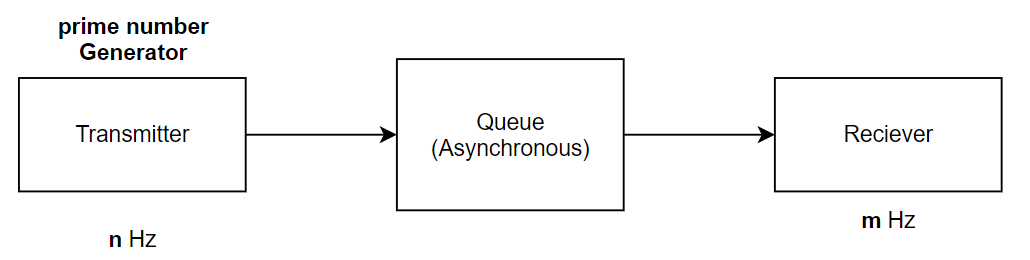

### <center> rough sketch</center>  

<br/> 
<br/> 

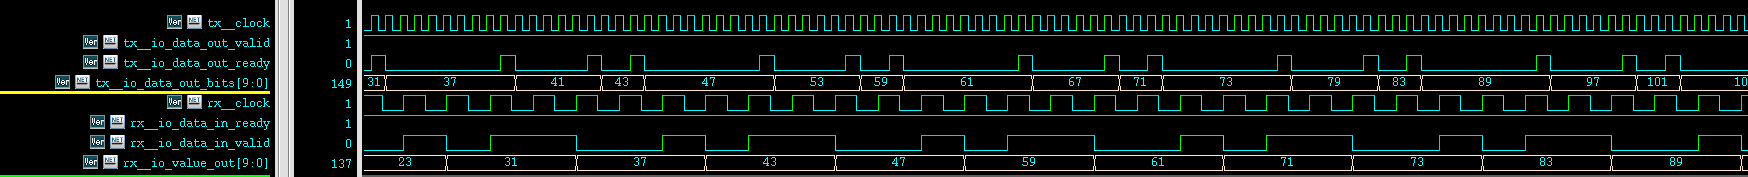

### <center> example Result </center>  

<center> (tx and rx clock get different frequencies and the timing is controlled by ready/valid signals) </center>

<br/> 
<br/> 

## 1.  AsyncCrossing 

<br/>
This **asyncCrossing module** Scala code describes "rough sketch" seen above.
<br/>

``` scala
class AsyncCrossing extends Module {

  class AsyncCrossingIO extends Bundle {
      val value_out: UInt = Output(UInt(10.W))
  }

  val io: AsyncCrossingIO = IO(new AsyncCrossingIO)

  val tx_clock: Clock = ClockDivider(clock, 4)
  val rx_clock: Clock = ClockDivider(clock, 12)

  val tx: TransmitModule = withClockAndReset(clock = tx_clock, reset = reset) { Module(new TransmitModule) }
  val rx: ReceiveModule = withClockAndReset(clock = rx_clock, reset = reset) { Module(new ReceiveModule) }

  io.value_out := rx.io.value_out

  val async_crossing: AsyncQueue[UInt] = Module(new AsyncQueue(UInt(10.W), AsyncQueueParams.singleton()))

  async_crossing.io.enq_clock := tx_clock
  async_crossing.io.deq_clock := rx_clock
  async_crossing.io.enq <> tx.io.data_out
  async_crossing.io.deq <> rx.io.data_in

  async_crossing.io.enq_reset := DontCare
  async_crossing.io.deq_reset := DontCare

}

```


1. The module ClockDivider generates a clock different from the default clock. So it creates fake clocks, and lets the modules run at different frequencies so we can test it
<br/>

2. TransmitModule(tx) and ReceiveModule(rx) have their own clock. and each module has to be inside of **withClockAndReset(or 
withClock)** if they are desired to be operated by their own clock.
<br/>

3. **AsyncQueue[T <: Data]** is provided method in the rocketchip.util. You can use this one for this example AsyncCrossing
<br/>

4. async_crossing(: AsyncQueue) IO must binding enq/deq decoupled and clocks
<br/>

5. **":="** makes simple binding. **"<>"** makes bi-directionally bulk connecting


<br/>

## 2.  Ready/Valid Protocol


<br/>

**valid** - output from producer indicating sending data

**ready** - output from consumer indicating able to receive

Transfer occurs when both ready & valid in same cycle



<br/>
<br/>

### **Protocol sceme**
<br/>

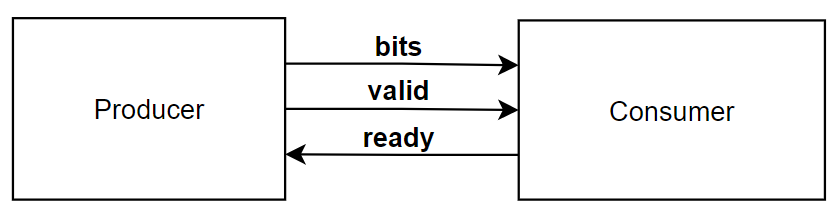


<br/>
<br/>


### <center> Producer & Consumer linked with Ready/Valid protocol  </center>  

<br/>
<br/>
<br/>

###  **IO feature**

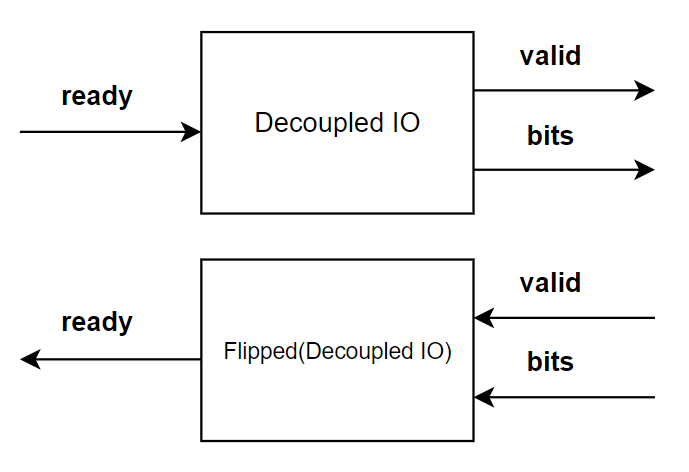

### <center> Input/Output bundle is supplied as "Decoupled"  </center>  


<br/><br/><br/>

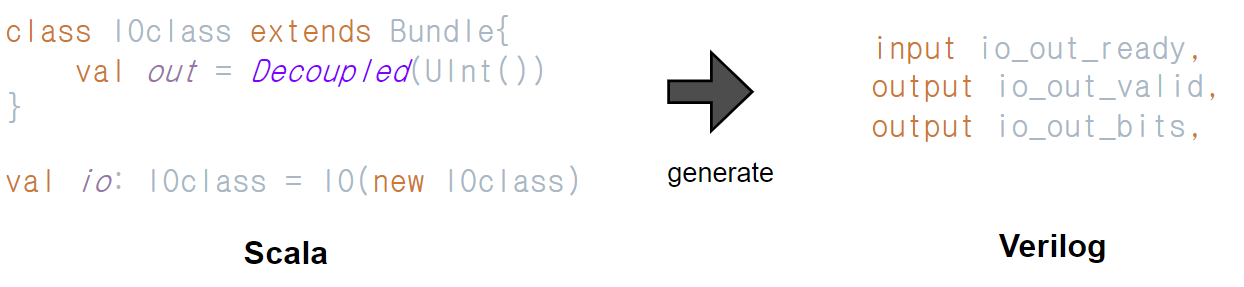


####  <center> If you declare Decoupled IO, the above three signals(input ready,output valid, out bits) are generated in the module  </center>

<br/><br/>



###  **Basic Handshake model scheme**

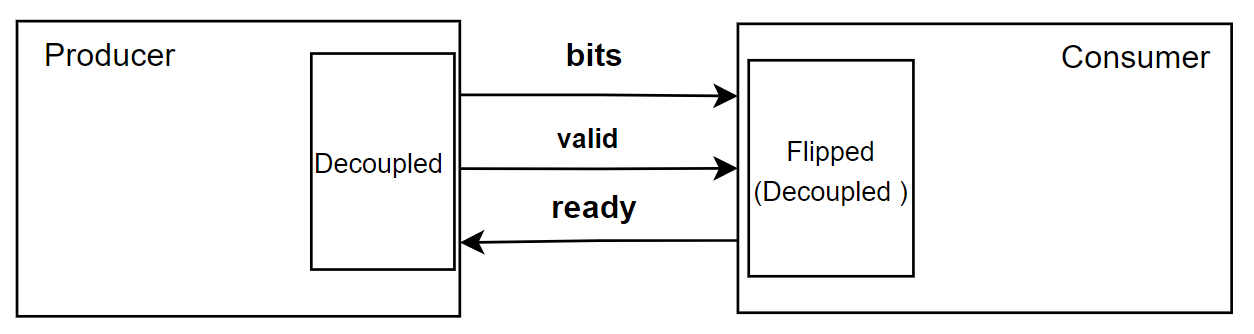

### <center> Producer & Consumer attached bundle model </center>  







## 3.  ClockDivider

package path :scala/functional/ClockDivider.scala


<br/>

### usage example 

``` scala
val generatedClock = ClockDivider(baseClock, 4)

```

![image.png](attachment:image.png)




<br /><br />

### **source code**

``` scala

import chisel3._
import chisel3.util.log2Ceil

object ClockDivider {
  /**
   * Create a clock divider.
   * @param clock_in Clock signal to divide.
   * @param divide_by Factor to divide by (e.g. divide by 2). Must be even.
   * @param reset Optional reset signal.
   * @return Divided clock.
   */
  def apply(clock_in: Clock, divide_by: Int, reset: Option[Bool] = None): Clock = {
    require(divide_by % 2 == 0, "Must divide by an even factor")

    // Declare some wires for use in this function.
    val output_clock = Wire(Clock())
    val resetWire = Wire(Bool())
    resetWire := reset.getOrElse(false.B)

    withClockAndReset(clock=clock_in, reset=resetWire) {
      // Divide down by n means that every n/2 cycles, we should toggle
      // the new clock.
      val max: Int = divide_by / 2
      // log2Ceil(n) = the # of bits needed to represent n unique things
      val counter = RegInit(0.U(log2Ceil(max).W))
      counter := counter + 1.U // The counter always increments.

      // Every second cycle, toggle the new divided down clock.
      val dividedDownClock = RegInit(false.B)
      when (counter === (max - 1).U) {
        dividedDownClock := ~dividedDownClock
        counter := 0.U
      }

      // Connect the register for the divided down clock to the output IO.
      output_clock := dividedDownClock.asClock
    }
    output_clock
  }
}
```

## 4.  Transmitter/Reciever module

package path :scala/chiselExample/exampleModule/queue/asyncExample/TransmitModule.scala

<br/>

1. the prime numbers are hardcoded in a Seq[Int] about 1 ~ 800. the Seq corresponds to the counter numbers in a Mux module. if clock runs, primenumberis generated sequentially and repeatedly

2. receiver module always take values without delay. so **"ready"** always generates **"true"** <br> if **true** valid signal comes with bits then receiver immediately process them

<br/>

![image-2.png](attachment:image-2.png)

### <center> Primenumber Generator module </center>  

<br />

![image-3.png](attachment:image-3.png)
### <center> Transmit Module </center>  


<br/><br/><br/><br/><br/><br/><br/>

### **source code**

<br/><br/>

**TransmitModule.scala**
``` scala

import chisel3.util.{Counter, Decoupled, DecoupledIO, MuxLookup}
import chisel3._

object AsyncCrossingValue {
  def values: Seq[Int] =
    Seq(2, 3, 5, 7,11, 13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97,101,103,107,109,113,127,131,137,139,
      149,151,157,163,167,173,179,181,191,193,197,199,211,223,227,229,233,239,241,251,257,263,269,271,277,281,283,293,
      307,311,313,317,331,337,347,349,353,359,367,373,379,383,389,397,401,409,419,421,431,433,439,443,449,457,461,463,
      467,479,487,491,499,503,509,521,523,541,547,557,563,569,571,577,587,593,599,601,607,613,617,619,631,641,643,647,
      653,659,661,673,677,683,691,701,709,719,727,733,739,743,751,757,761,769,773,787,797,809)
}

class TransmitModule extends Module {

  class TransmitModule extends Bundle{
    val data_out: DecoupledIO[UInt] = Decoupled(UInt(10.W))
  }

  val io: TransmitModule = IO(new TransmitModule)

  io.data_out.valid := false.B
  io.data_out.bits := DontCare

  val counter: Counter = Counter(AsyncCrossingValue.values.length + 1)

  when (counter.value < AsyncCrossingValue.values.length.U) {

    val candidateValue = MuxLookup(counter.value, 0.U,
      AsyncCrossingValue.values.zipWithIndex.map {
        case (value: Int, index: Int) => (index.U, value.U)
      })
    io.data_out.enq(candidateValue)

    when (io.data_out.fire) {
      counter.inc()
    }.otherwise{
      counter.value := counter.value
    }
  }.otherwise{
    counter.value := 0.U
  }
}

```


<br/>

**ReceiveModule.scala**

<br/>

``` scala 
import chisel3.util.Decoupled
import chisel3._

class ReceiveModule extends Module {
  val io = IO(new Bundle {
    val data_in = Flipped(Decoupled(UInt(10.W)))
    val value_out = Output(UInt(10.W))
  })
  // RX is always ready
  io.data_in.ready := true.B
  // When data is transmitted, update output.
  val output: UInt = RegInit(0.U)
  io.value_out := output

  when(io.data_in.fire) {
    output := io.data_in.bits
  }.otherwise{

  }
}
```